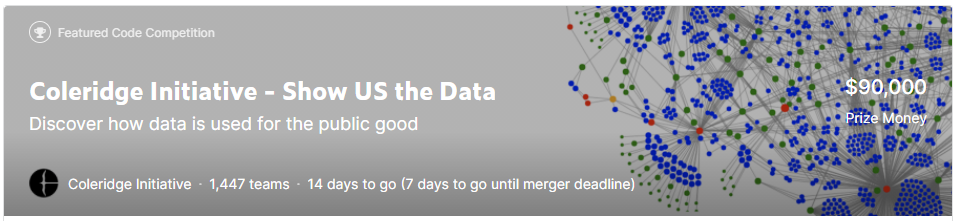


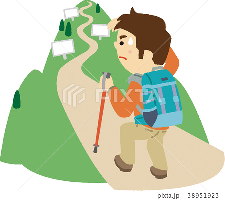

このコンペの目的は、<br>
”簡単に言えば、学術論文の全文章内容から、dataset_labelという何について書かれているかの分類分けをするコンペだと思います。”<br>
https://www.kaggle.com/chumajin/coleridge-initiative-eda-for-biginner　より引用。なるほど。<br>
これだけだと全員同じスコアになるので、外部データ（科学出版物のデータ）を取り込むことが必要だと思います。

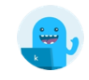

コンテストの目的は、科学出版物内のデータセットの言及を特定することです。あなたの予測は、データセットに注目しているように見える出版物からの短い抜粋です。パブリケーション内のデータセットを識別するために使用される正確な単語とより正確に一致する予測は、より高いスコアになります。予測は、適切に一致するように、評価ページのclean_text関数を使用してクリーンアップする必要があります。

def jaccard(str1, str2): <br>
    a = set(str1.lower().split()) <br>
    b = set(str2.lower().split())<br>
    c = a.intersection(b)<br>
    return float(len(c)) / (len(a) + len(b) - len(c))<br>
    
def clean_text(txt):<br>
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())<br>
    
提出物は、予測テキストとグラウンドトゥルーステキストの間のJaccardベースのFBetaスコアで評価され、ベータ= 0.5（マイクロF0.5スコア）です。 複数の予測は、送信ファイル内でパイプ（|）文字で示されます。

各出版物の一連の予測について、トークンベースのJaccardスコアが、潜在的な予測/グラウンドトゥルースのペアごとに計算されます。 特定のグラウンドトゥルースのスコアが最も高い予測は、そのグラウンドトゥルースと一致します。

各出版物の予測文字列はアルファベット順にソートされ、その順序で処理されます。 スコアリングの同点は、そのソートに基づいて解決されます。
Jaccardスコアがしきい値0.5を満たすか超える一致した予測は、真陽性（TP）としてカウントされ、残りは偽陽性（FP）としてカウントされます。
一致しない予測は、誤検知（FP）としてカウントされます。
最も近い予測がないグラウンドトゥルースは、フォールスネガティブ（FN）としてカウントされます。
すべてのサンプルのすべてのTP、FP、およびFNを使用して、最終的なマイクロF0.5スコアが計算されます。 （マイクロFスコアはこれを正確に実行し、予測のセット全体のスコアを計算するために使用されるTP、FP、およびFNの1つのプールを作成することに注意してください。）

<br>
初めてまともに向かいあいましたが、手も足もでないという感じですした。<br>結果がでました。５００位にも届きませんでした。😭<br>
Bertをもっと勉強しなきゃ。

# パラメタ

In [ ]:
COMPUTE_CV = False #なかなかすごいです。パラメータによってある程度、複数の課題に対応できるようにしている。
EDA_DEMO = False
ALL_BLENDED = False
BASELINE_HELPING = False
MATCH_ONLY = False
MLM_ONLY = False
KEN_MATCHING = True
BS_CLEANING = False
THEO_MERGE = False
SEED = 40 #縁起が悪い数字だったので変えてみる

# Bertインストール

In [ ]:
!pip install datasets --no-index --find-links=file:///kaggle/input/coleridge-packages/packages/datasets #これをやるとインターネットをみにいかなくのるのかな？
!pip install ../input/coleridge-packages/seqeval-1.2.2-py3-none-any.whl
!pip install ../input/coleridge-packages/tokenizers-0.10.1-cp37-cp37m-manylinux1_x86_64.whl
!pip install ../input/coleridge-packages/transformers-4.5.0.dev0-py3-none-any.whl

from IPython.display import clear_output
clear_output()

# Import

In [ ]:
import os
import re
import json
import time
import random
import glob
import importlib

import numpy as np
import pandas as pd

from tqdm.autonotebook import tqdm

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, \
AutoModelForMaskedLM, Trainer, TrainingArguments, pipeline

from typing import List
import string
from functools import partial
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True #torch.backends.cudnn.deterministic = True とすると決定論的振る舞いをするらしいです。
torch.backends.cudnn.benchmark = False # torch.backends.cudnn.benchmark = True はここ曰く、CNNの様にinput_sizeが固定なら高速化が期待できるらしい

sample_submission = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
if len(sample_submission) > 4: COMPUTE_CV = False
if COMPUTE_CV: 
    print('this submission notebook will compute CV score but commit notebook will not')
else:
    print('this submission notebook will only be used to submit result')

# Load data

In [ ]:
train_path = '../input/coleridgeinitiative-show-us-the-data/train.csv'
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
train = pd.read_csv(train_path)

if COMPUTE_CV: 
    sample_submission = train
    paper_test_folder = '../input/coleridgeinitiative-show-us-the-data/train'
    test_files_path = paper_test_folder
else: #こちらが動く
    sample_submission = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
    paper_test_folder = '../input/coleridgeinitiative-show-us-the-data/test'
    test_files_path = paper_test_folder
adnl_govt_labels_path = '../input/govt-dataset-list/data_set_800.csv'

In [ ]:
train

🎉testフォルダのjsonファイルをすべて読み込む。

In [ ]:
papers = {}
for paper_id in tqdm(sample_submission['Id']):
    with open(f'{paper_test_folder}/{paper_id}.json', 'r') as f:
        paper = json.load(f)
        papers[paper_id] = paper

##  EDA

🎉trainデータのjsonファイルをpandasへ読み込む。<br>
🎉copy(deep=True)の指定もできるんだ。

In [ ]:
if EDA_DEMO:
    df_input = pd.DataFrame(columns=['id','section_title','text','data_label'])
    for id in tqdm(train['Id'].values):
        df=pd.read_json('../input/coleridgeinitiative-show-us-the-data/train/{}.json'.format(id))   
        #trainのidは同じものが複数あるのでそれをまとめて、そしてdataset_labelが一致するものを探す。
        for data_label in train[train['Id']==id]['dataset_label'].values:        
            new_df=df[df['text'].str.contains(data_label)].copy(deep=True) #jsonファイルの'text'に trainのdatalabelが含まれているものをコピーする
            new_df.loc[:,['data_label']] = data_label
            new_df.loc[:,['id']] = id
            new_df.reset_index(inplace=True,drop=True)
            df_input=pd.concat([df_input, new_df], ignore_index=True)
            df_input.reset_index(inplace=True,drop=True)
else: df_input = None
    
#train
df_input

🎉各変数の値をみてみる。

In [ ]:
train[train['Id']==id]['dataset_label'].values #train idは同じだがdataset_labelは異なる。

In [ ]:
if EDA_DEMO: df_input = df_input[ df_input['section_title'] != '' ]

df_input

# Literal Matching

### Create a Knowledge Bank

📌1行ずつ取り出すメソッドにはiterrows()とitertuples()がある。itertuples()のほうが高速だそうです。

In [ ]:
all_labels = set()

for label_1, label_2, label_3 in train[['dataset_title', 'dataset_label', 'cleaned_label']].itertuples(index=False):
    all_labels.add(str(label_1).lower())
    all_labels.add(str(label_2).lower())
    all_labels.add(str(label_3).lower())
    
print(f'No. different labels: {len(all_labels)}')

180種類ある。10件だけ出力してみる。タイトルとしては長いような気がします。🎨

In [ ]:
a=0
for i in all_labels:
    print(i)
    a+=1
    if a==10:
        break

#### 📌件数がすごい増えているからこれがこのnotebookのキーか。kenさんという人が作っているもの。

In [ ]:
adnl_govt_labels = pd.read_csv(adnl_govt_labels_path)

for l in adnl_govt_labels.title:
    
  all_labels.add(l)
print(f'No. different labels: {len(all_labels)}')

🎉一旦はずす
@ mlconsultによって提供された元のdata_set_800に追加されたData.govから、人気のある上位22,000のgov_datasetを収集しました(discussionより）<br>
これが主催者の求めるものなのかどうかがよくわからない。<br>

一旦はずす
https://www.kaggle.com/mlconsult/100000-govt-datasets-api-json-to-df/output?scriptVersionId=64010594&select=datasets.csv

discusstionにあったlabelを追加

In [ ]:
add_labels = open('../input/jelaladdtxt/data.txt', 'r')
data = add_labels.read()
#add_labels.close()


for l in data:
    all_labels.add(l)
    
all_labels = set(all_labels)
print(f'No. different labels: {len(all_labels)}')

### Matching on test data

In [ ]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()


def totally_clean_text(txt):
    txt = clean_text(txt)
    txt = re.sub(' +', ' ', txt)
    return txt

if not BS_CLEANING:
    def text_cleaning(text):
        '''
        すべてのテキストを小文字に変換し、特殊文字、絵文字、複数のスペースを削除します。テキスト - クリーンアップが必要な文
        '''
        text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
        text = re.sub(' +', ' ', text)
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # 顔文字
                                   u"\U0001F300-\U0001F5FF"  # 記号と絵文字
                                   u"\U0001F680-\U0001F6FF"  # 交通及び地図記号
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)
        return text
else:
    def text_cleaning(text):
        '''
        すべてのテキストを小文字に変換し、特殊文字、絵文字、複数のスペースを削除します。テキスト - クリーンアップが必要な文
        '''
        text = ''.join([k for k in text if k not in string.punctuation])
        text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
        # text = re.sub("/'+/g", ' ', text)
        return text


def read_json_pub(filename, train_data_path=train_files_path, output='text'):
    json_path = os.path.join(train_data_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data

In [ ]:
if not KEN_MATCHING and not MLM_ONLY: #動かない
    literal_preds = []
    for paper_id in tqdm(sample_submission['Id']):
        paper = papers[paper_id]
        text_1 = '. '.join(section['text'] for section in paper).lower()
        text_2 = totally_clean_text(text_1)

        labels = set()
        for label in all_labels:
            if label in text_1 or label in text_2:
                labels.add(clean_text(label))

        literal_preds.append('|'.join(labels))
    literal_preds[:5]

#### 追加データセットのキーワードが本文に含まれているか😷

PubMed（パブメド）は生命科学や生物医学に関する参考文献や要約を掲載するMEDLINEなどへの無料検索エンジンである。 アメリカ国立衛生研究所のアメリカ国立医学図書館（NLM）が情報検索Entrezシステムの一部としてデータベースを運用している。

In [ ]:
literal_preds = []

if KEN_MATCHING and not MLM_ONLY:
    literal_preds = []
    to_append = []
    for index, row in tqdm(sample_submission.iterrows()):
        to_append = [row['Id'],'']
        large_string = str(read_json_pub(row['Id'], test_files_path))
        clean_string = text_cleaning(large_string)
        #print(clean_string)
        for index, row2 in adnl_govt_labels.iterrows():
            query_string = str(row2['title'])
            if query_string in clean_string:
              #if query_string !='progress in international reading literacy study': @@
                #print('+',query_string)
                if to_append[1] != '' and clean_text(query_string) not in to_append[1]:
                    to_append[1] = to_append[1] + '|' + clean_text(query_string)
                if to_append[1] == '':
                    to_append[1] = clean_text(query_string)
        #print(to_append)
        literal_preds.append(*to_append[1:])

elif MLM_ONLY:
    print('This kernel will only use MLM model to predict.')

この文字列はto_appendに追加していない。これは、clean_string(jsonの文章にない）になかったから。

In [ ]:
clean_text(query_string)

この文字列がto_appendになければ追加している。これは、最後のループでの結果。

In [ ]:
to_append[1]

In [ ]:
#literal_preds #これだとどうなるんだろう？

In [ ]:
sample_submission['PredictionString'] = literal_preds
sample_submission[['Id', 'PredictionString']].to_csv('submission2.csv', index=False)


0.577

得たいの知れないデータセットの中身。これが本文中にあれば、追加している。このデータセットを作れるかできまってくる。どうやってつくるんだろう。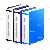

# Masked Dataset Modeling🔎

### Paths and Hyperparameters

In [ ]:
if not MATCH_ONLY:
    PRETRAINED_PATH = '../input/coleridge-bert-mlmv4/output-mlm/checkpoint-48000' ##checkpoint-48000を変えてみたがスコアがおちたのでもとにもどしました。
    TOKENIZER_PATH = '../input/coleridge-bert-mlmv4/model_tokenizer'

    MAX_LENGTH = 64
    OVERLAP = 20

    PREDICT_BATCH = 32 # GPUのメモリ上このあたりが限界か

    DATASET_SYMBOL = '$' # this symbol represents a dataset name
    NONDATA_SYMBOL = '#' # this symbol represents a non-dataset name

### Load model and tokenizer🎉

In [ ]:
if not MATCH_ONLY:
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH, use_fast=True)
    model = AutoModelForMaskedLM.from_pretrained(PRETRAINED_PATH)

    mlm = pipeline( 
        'fill-mask', 
        model=model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1
    )
    
#from transformers import AutoTokenizer, DataCollatorForLanguageModeling, \   pipelineはtransformersからimportしている。
#AutoModelForMaskedLM, Trainer, TrainingArguments, pipeline

パイプラインは、推論にモデルを使用するための優れた簡単な方法です。 これらのパイプラインは、ライブラリから複雑なコードのほとんどを抽象化するオブジェクトであり、名前付きエンティティの認識、マスクされた言語モデリング、感情分析、特徴抽出、質問応答など、いくつかのタスク専用のシンプルな API を提供します。<br>
ModelWithLMHead を使用したマスクされた言語モデリング予測パイプライン。 <br>
このマスク充填パイプラインは、現在、次のタスク識別子を使用して pipeline() からロードできます: "fill-mask"。<br>
このパイプラインで使用できるモデルは、マスクされた言語モデリングの目的でトレーニングされたモデルです。これには、ライブラリ内の双方向モデルが含まれます<br>

難しい。。。。

### Auxiliary functions🎉

In [ ]:
def jaccard_similarity(s1, s2):
    l1 = s1.split(" ")
    l2 = s2.split(" ")    
    intersection = len(list(set(l1).intersection(l2))) #intersectionで配列同士の重複を集合させる（積集合）　同じものがあれば抽出の意味のようです。
    union = (len(l1) + len(l2)) - intersection
    return float(intersection) / union #これで何がわかるのか？類似性がわかる？

def clean_paper_sentence(s):
    """
   この関数は、基本的に小文字のない clean_text です。
    """
    s = re.sub('[^A-Za-z0-9]+', ' ', str(s)).strip()
    s = re.sub(' +', ' ', s)
    return s

def shorten_sentences(sentences):
    """
    MAX_LENGTH単語以上の文は分割されます
     重複して複数の文に。
    """
    short_sentences = []
    for sentence in sentences:
        words = sentence.split()
        if len(words) > MAX_LENGTH:
            for p in range(0, len(words), MAX_LENGTH - OVERLAP):
                short_sentences.append(' '.join(words[p:p+MAX_LENGTH]))
        else:
            short_sentences.append(sentence)
    return short_sentences

#変えてみる
connection_tokens = {'s', 'of', 'and', 'in', 'on', 'for', 'data', 'dataset'} #なんでこれにしている？📌
#connection_tokens= {'ourselves', 'hers','the','of','and','in', 'between', 'yourself', 'but', 'again','of', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'}
    
def find_mask_candidates(sentence):
    """
   　指定された $sentence から Masked Dataset Modeling のマスキング候補を抽出します。
     候補は、少なくとも 2 単語の連続するものでなければなりません。
     これらの各単語は、最初の文字が大文字であるか、次のいずれかです。
     接続ワード ($connection_tokens)。 さらに、接続は
     トークンの最初と最後に出現することは許可されていません。
     シーケンス。 
    """
    def candidate_qualified(words):
        while len(words) and words[0].lower() in connection_tokens: #📌
            words = words[1:]
        while len(words) and words[-1].lower() in connection_tokens: #📌
            words = words[:-1]
        
        return len(words) >= 2
    
    candidates = []
    
    phrase_start, phrase_end = -1, -1 #-1が入ってる。
    for id in range(1, len(sentence)):
        word = sentence[id]
        if word[0].isupper() or word in connection_tokens:
            if phrase_start == -1:
                phrase_start = phrase_end = id
            else:
                phrase_end = id
        else:
            if phrase_start != -1:
                if candidate_qualified(sentence[phrase_start:phrase_end+1]):
                    candidates.append((phrase_start, phrase_end))
                phrase_start = phrase_end = -1
    
    if phrase_start != -1:
        if candidate_qualified(sentence[phrase_start:phrase_end+1]):
            candidates.append((phrase_start, phrase_end))
    
    return candidates

### Transform

In [ ]:
if not MATCH_ONLY:
    mask = mlm.tokenizer.mask_token
    all_test_data = []
    
    for paper_id in tqdm(sample_submission['Id']):
        # load paper
        paper = papers[paper_id]

        # extract sentences
        sentences = set([clean_paper_sentence(sentence) for section in paper #作った関数を使ってる。
                         for sentence in section['text'].split('.')
                        ])
        sentences = shorten_sentences(sentences) # 作った関数を呼んでいる。
        sentences = [sentence for sentence in sentences if len(sentence) > 1] # lengthが１より大きいものだけ抽出。１は抽出しない。
        sentences = [sentence for sentence in sentences if any(word in sentence.lower() for word in ['data', 'study'])] #小文字に変換
        sentences = [sentence.split() for sentence in sentences] # senteceをsplitで分割している。

        # mask
        test_data = []
        for sentence in sentences:
            for phrase_start, phrase_end in find_mask_candidates(sentence): 
                dt_point = sentence[:phrase_start] + [mask] + sentence[phrase_end+1:]
                test_data.append((' '.join(dt_point), ' '.join(sentence[phrase_start:phrase_end+1]))) 

        all_test_data.append(test_data)

In [ ]:
mask 

In [ ]:
sentences[0]

### Predict

In [ ]:
if not MATCH_ONLY:
    pred_mlm_labels = []

    for test_data in tqdm(all_test_data):
        pred_bag = set()

        if len(test_data):
            texts, phrases = list(zip(*test_data))
            mlm_pred = []
            for p_id in range(0, len(texts), PREDICT_BATCH):
                batch_texts = texts[p_id:p_id+PREDICT_BATCH]
                batch_pred = mlm(list(batch_texts), targets=[f' {DATASET_SYMBOL}', f' {NONDATA_SYMBOL}'])

                if len(batch_texts) == 1:
                    batch_pred = [batch_pred]

                mlm_pred.extend(batch_pred)

            for (result1, result2), phrase in zip(mlm_pred, phrases):
                if (result1['score'] > result2['score']*2 and result1['token_str'] == DATASET_SYMBOL) or\
                   (result2['score'] > result1['score']*2 and result2['token_str'] == NONDATA_SYMBOL):
                    pred_bag.add(clean_text(phrase))

        # filter labels by jaccard score 
        filtered_labels = []

        for label in sorted(pred_bag, key=len, reverse=True): #jaccard_similarityが0.75未満となっている。なぜでしょう。評価基準どおり0.5にしよう。@
            if len(filtered_labels) == 0 or all(jaccard_similarity(label, got_label) < 0.5 for got_label in filtered_labels):
                filtered_labels.append(label)

        pred_mlm_labels.append('|'.join(filtered_labels))
    
    pred_mlm_labels[:5]

In [ ]:
pred_mlm_labels[:5]

# Baseline Model📌

In [ ]:
def read_append_return(filename, train_files_path=train_files_path, output='text'):
    """
    Function to read json file and then return the text data from them and append to the dataframe
    """
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title')) #jsonの形式は、このとおり。
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data
    
    
def text_cleaning(text):
    '''
    すべてのテキストを小文字に変換し、特殊文字、絵文字、複数のスペースを削除します。テキスト - クリーンアップが必要な文
    '''
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
    # text = re.sub("/'+/g", ' ', text)
    return text

In [ ]:
if BASELINE_HELPING or ALL_BLENDED: #動いてない
    tqdm.pandas()

    train['text'] = train['Id'].progress_apply(read_append_return)

    if not COMPUTE_CV:
        sample_submission['text'] = sample_submission['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))

In [ ]:
train.head()

In [ ]:
if BASELINE_HELPING or ALL_BLENDED:
    tqdm.pandas()
    
    train['text'] = train['text'].progress_apply(text_cleaning)

In [ ]:
if BASELINE_HELPING or ALL_BLENDED:
    temp_1 = [x.lower() for x in train['dataset_label'].unique()]
    temp_2 = [x.lower() for x in train['dataset_title'].unique()]
    temp_3 = [x.lower() for x in train['cleaned_label'].unique()]

    existing_labels = set(temp_1 + temp_2 + temp_3)

    print(f'len(temp_1) = {len(temp_1)}')
    print(f'len(temp_2) = {len(temp_2)}')
    print(f'len(temp_3) = {len(temp_3)}')
    print(f'len(existing_labels) = {len(existing_labels)}')

    id_list = []
    lables_list = []
    for index, row in tqdm(sample_submission.iterrows()):
        sample_text = row['text']
        row_id = row['Id']
        temp_df = train[train['text'] == text_cleaning(sample_text)]
        cleaned_labels = temp_df['cleaned_label'].to_list()

        for known_label in existing_labels:
            if known_label in sample_text.lower():
                cleaned_labels.append(clean_text(known_label))

        cleaned_labels = [clean_text(x) for x in cleaned_labels]
        cleaned_labels = set(cleaned_labels)
        lables_list.append('|'.join(cleaned_labels))
        id_list.append(row_id)

## 最終予測を集約し、提出ファイルを作成します  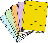

In [ ]:
pred_mlm_labels

In [ ]:
final_predictions = []

if ALL_BLENDED: #false
    for literal_match, mlm_pred, lables_match in zip(literal_preds, pred_mlm_labels, lables_list):
        temp = [literal_match, mlm_pred, lables_match]
        temp = [pred for pred in temp if pred]
        temp = ('|').join(temp)
        final_predictions.append(temp)
        
elif BASELINE_HELPING: #false
    for literal_match, mlm_pred, lables_match in zip(literal_preds, pred_mlm_labels, lables_list):
        if literal_match:
            final_predictions.append(literal_match)
        elif lables_match:
            final_predictions.append(lables_match)
        else:
            final_predictions.append(mlm_pred)

elif MATCH_ONLY: #false
    final_predictions = literal_preds

elif MLM_ONLY: #false
    final_predictions = pred_mlm_labels

elif THEO_MERGE: #false
    for i in range(len(literal_preds)):
        pred_naive = literal_preds[i].split('|')
        pred_model = pred_mlm_labels[i].split('|')
        pred_model_kept = []
        for pred_m in pred_model:
            kept = True
            for pred_n in pred_naive:
                if pred_m in pred_n or pred_n in pred_m:
                    kept = False
            if kept:
                pred_model_kept.append(pred_m)
        final_predictions.append("|".join(pred_naive + pred_model_kept))

else:
    for literal_match, mlm_pred in zip(literal_preds, pred_mlm_labels):
        if literal_match:
            final_predictions.append(literal_match)
        else:
            final_predictions.append(mlm_pred)

sample_submission['PredictionString'] = final_predictions

In [ ]:
mlm_pred

In [ ]:
literal_match

In [ ]:
sample_submission[['Id', 'PredictionString']].to_csv('submission.csv', index=False)

#sample_submission

# <ディスカッションヒント><br>
・コンテストの目的は、データセットを取り巻くコンテキストを理解することです (これが、社内で競合を「リッチ コンテキスト」と呼んでいる理由です)。 このアプローチは、研究者が新たに出現したデータセットをどのように参照するかを特定するのにも役立ちます。たとえば、新たに出現した数の COVID データセットに適用される多くの異なる名前などです。<br>
・重要なのは、両方の名前がデータセットを参照しているため、それに応じてコーディングできるということです。 巨大なルックアップテーブルの作成を推奨するのではなく、データセットが呼び出されたセマンティックコンテキストの識別を推奨します。<br>
・トレーニングラベルはノイズが多く、さまざまな形式の「メンション」をデータセットに正しく適用できることを示すことを目的としています。 たとえば、AGIDのようなデータセットは、「（AGID）」なしで他の場所で言及される可能性があるため、その一意の文字列に一致することを学習するだけでは、タスクを解決するには不十分です。<br>
・ここで、すべての（複数の）クリーンアップされたラベルは、同じデータセット、つまり「国立空間オブジェクトの場所データセット」を参照しています。<br>
・trainデータには同じデータセットの複数のラベルが含まれていることはすでにわかっています<br>
・経験科学の出版物で複数のデータセットを参照することは非常に標準的です。 実際、これは政府機関が関心を持っている指標の1つであり、データセットが経験的エコシステムにどのように適合するかを理解しています。 したがって、出版物のデータセットの共参照は非常に有用な結果の尺度です<br>
・タスクは、データセットの言及のセマンティックコンテキストを識別することです。 テストデータには、トレーニングセットではまったく表示されない非常に多くのデータセット、コンテキスト、およびパブリケーションが含まれています。 モデルがうまく機能するには、タスクに一般化する必要があります。<br>
・このコンテストの課題の1つは、テキストの長さです。 ほとんどのセクションは512トークンより長く、これは従来のトランスフォーマーの制限です。<br>
・テストセットではグラウンドトゥルースはあまり正確ではなく、トレーニングセットは完全にIMOとラベル付けされていないと思います。 政府のデータであり、ラベル付けされたトレーニングデータに含まれていないこれらのデータセット（多くを手作業でチェック）を見つけました。 これらのデータセットを「isin」テストに追加すると、スコアが70％から67％に低下します。これは、システムがテストドキュメントでこれらのデータセットの一部を検出していることを示していますが、これらはグラウンドトゥルースではない可能性があります。 。 明らかに、これらの一部が適切なデータセットやタイトルなどではない可能性がありますが、これは、これらすべてのドキュメントでどのようにグラウンドトゥルースを作成したかという点を示しています-徹底的なラベリングシステムが私たちが構築しようとしているもののようです。 それで、彼らがそれを持っているのなら、なぜ彼らは私たちを必要とするのですか？ 彼らが手作業でグラウンドトゥルースを行っている場合、それがすべての政府のデータセットと引用のバリエーションをキャッチしているとは考えにくいです。<br>
・トレーニングセットには、頭字語のみでラベル付けされているように見える場合もあれば、データセット名でラベル付けされている場合もあります。 時には両方。 全く分からない。<br>
・訓練データでは、犯罪と安全に関する学校の調査を見落としていたようです。 申し訳ありません。 したがって、基本的に、犯罪と安全性に関する調査も照合すると、重複が追加され、スコアが低くなります。 理にかなっています。<br>
・トレーニングセット内の任意のラベルで、ジャカードが0.5以上の予測ラベルをすべて削除しましたか？=>修正しました<br>
・スクラピングツールを作成して上級者はデータセットを作成している。<br>
　https://www.kaggle.com/chienhsianghung/web-scraping-for-bigger-govt-dataset-list
  https://www.kaggle.com/mlconsult/100000-govt-datasets-api-json-to-df?scriptVersionId=64010594
・特定の出版物について、著者がその研究論文で使用したデータセットを見つけるように求められます。
これらは、データセットに言及しているように見える出版物からの短い抜粋です。 パブリケーションは複数のデータセットを参照できるため、複数のデータセットの名前を '|で区切って含めることもできます。 '。 同様に、出版物のグラウンドトゥルースでさえ、複数のデータセットがあります。したがって、特定のパブリケーションについて、グラウンドトゥルースラベルとともに「|」で区切られた一連の予測があります（現在、単一のパブリケーションのtrain.csvに複数のエントリとして指定されていますが、いくつかの変換を使用すると、次のように取得できます。 同じ形式）。特定のグラウンドトゥルースの類似度スコアが最も高い予測は、そのグラウンドトゥルースと一致します。 そのグラウンドトゥルースの他の予測は、比類のないものと呼ばれます。 最高の類似性スコアに同点がある場合は、予測文字列をアルファベット順に並べ替えることで解決されます。F0.5スコア：F 0.5は、F1（適合率と再現率を等しく重み付けする）とF0（適合率）の間の尺度であると思います。 F 0.5は（F0とは異なり）False Negativesを考慮に入れますが、精度に偏ります。<br>
・testデータでは、まったく言及されていないラベルが多数あります。 したがって、タスクは文字列を照合することではなく、「このドキュメントに記載されているデータセットを特定できますか」という問題を一般化するためのNLPソリューションを作成することです。<br>
・

